In [1]:
%load_ext autoreload
%autoreload 2

import os
from glob import glob
from os.path import join

import calendar

import tqdm
import cftime
import dask

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import cm

from distributed import wait

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

%matplotlib inline

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='2:30:00', # Amount of wall time
        interface='ext', # Interface to use  'lo' provided a cluster window, below.
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient(nmem='5GB')
cluster.scale(20) 
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.112:44511,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/wwieder/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [ ]:
plat, plon = 38.9592, (360-106.9898) #coords for RMBL in Gothic
def preprocess (ds,plat=plat,plon=plon):

    LATI=ds.LATIXY.isel(time=0,lon=0).values
    LONG=ds.LONGXY.isel(time=0,lat=0).values
    ds = ds.assign_coords({"lon": LONG, 'lat':LATI})
    ds_new = ds.sel(lat=plat,lon=plon, method='nearest')

    return ds_new

In [ ]:
site = 'gothic'
plat, plon = 38.9592, (360-106.9898) #coords for RMBL in Gothic
#fin = '/glade/p/cgd/tss/CTSM_datm_forcing_data/atm_forcing.datm7.NLDAS2.0.125d.v2.c200908/'
#files through 2022
fin = '/glade/campaign/cgd/tss/people/swensosc/NLDAS'
ftypes = ['Precip','Solar','TPQWL']
dir_in = 'clmforc.NLDAS2.c2020.0125x0125.'
years = ['200','201','202'] 

#Can't combine datasets here because time intervals aren't the same, but unsure why for hourly data?
out_dir = '/glade/derecho/scratch/wwieder/nldas/'+site+'/'
out_dir = '/glade/campaign/cgd/tss/people/wwieder/'+site+'/'
if not os.path.isdir(out_dir):
    os.makedirs(out_dir, exist_ok=True)            

for ftype in ftypes: 
    print('starting '+ftype)
    for year in years:
        # list of files
        files = []
        #files.extend(sorted(glob(join(fin,ftype+dir_in+ftype+"."+year+"*.nc"))))
        # For Sean's data through 2022
        files.extend(sorted(glob(join(fin,'*'+ftype+"."+year+"*.nc"))))

        # Open datasets
        ds = xr.open_mfdataset(files, decode_times=True, combine='by_coords',parallel=True)

        # Assign coords
        LATI=ds.LATIXY.isel(time=0,lon=0).values
        LONG=ds.LONGXY.isel(time=0,lat=0).values
        ds = ds.assign_coords({'lon': LONG, 'lat':LATI})
        
        # Subset data & modify fillValues
        ds = ds.sel(lat=plat,lon=plon, method='nearest')
        ds= ds.expand_dims(dim={"lat": 1},axis=1)
        ds= ds.expand_dims(dim={"lon": 1},axis=2)
        ds['LONGXY'] = ds2['LONGXY'].isel(time=0)
        ds['LATIXY'] = ds2['LATIXY'].isel(time=0)
        ds['time'].attrs['_FillValue'] = 1.e36
        ds['LONGXY'].attrs['_FillValue'] = 1.e36
        ds['LATIXY'].attrs['_FillValue'] = 1.e36
        ds['lat'].attrs['_FillValue'] = 1.e36
        ds['lon'].attrs['_FillValue'] = 1.e36
        print('...loading data...')
        ds = ds.persist() 
        _ = wait(ds)

        fout = out_dir+'clmforc.NLDAS2.c2020.'+ftype+'.'+site+'.'+year+'0-'+str(int(year)*10+9)+'_nc4.nc'
        ds.to_netcdf(fout)
        print('wrote '+fout)
        

starting Precip


In [46]:
ds

<xarray.Dataset>
Dimensions:   (time: 8760, lat: 1, lon: 1)
Coordinates:
  * time      (time) object 2000-01-01 00:30:00.000054 ... 2000-12-31 23:29:5...
  * lon       (lon) float32 253.1
  * lat       (lat) float32 38.94
Data variables:
    LONGXY    (lat, lon) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    LATIXY    (lat, lon) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    PRECTmms  (time, lat, lon) float32 dask.array<chunksize=(744, 1, 1), meta=np.ndarray>
Attributes:
    creation_date:   
    conventions:     
    case_title:     NLDAS 1-Hourly Atmospheric Forcing: Precipitation

In [44]:

#ds2['lat']=ds2['lat'].assign_coords(lat=plat)
ds2
#for v in dsVar:
#    ds2[v]=ds2[v].assign_coords(lat=plat, lon=plon)
    


<xarray.Dataset>
Dimensions:   (time: 8760, lat: 1, lon: 1)
Coordinates:
  * time      (time) object 2000-01-01 00:30:00.000054 ... 2000-12-31 23:29:5...
  * lon       (lon) float32 253.1
  * lat       (lat) float32 38.94
Data variables:
    LONGXY    (time, lat, lon) float32 dask.array<chunksize=(744, 1, 1), meta=np.ndarray>
    LATIXY    (time, lat, lon) float32 dask.array<chunksize=(744, 1, 1), meta=np.ndarray>
    PRECTmms  (time, lat, lon) float32 dask.array<chunksize=(744, 1, 1), meta=np.ndarray>
Attributes:
    creation_date:   
    conventions:     
    case_title:     NLDAS 1-Hourly Atmospheric Forcing: Precipitation

In [12]:
ds = xr.open_dataset('/glade/scratch/wwieder/nldas/gothic/clmforc.NLDAS2.c2020.Solar.gothic.2010-2019.nc',
                     decode_times=True)

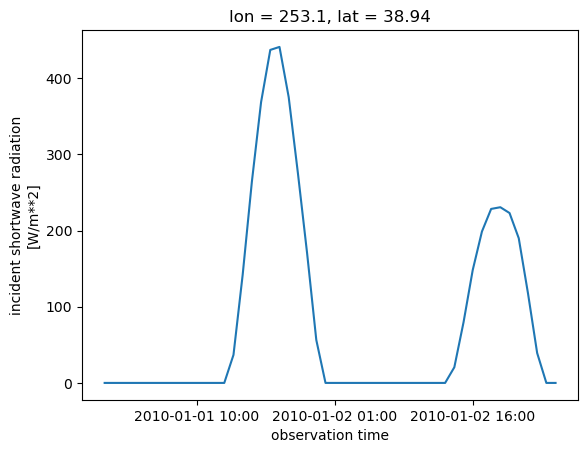

In [15]:
ds.FSDS.isel(time=slice(0,50)).plot()

In [17]:
# May have to manually write these to nc5

In [58]:
ds = xr.open_dataset('/glade/scratch/wwieder/nldas/gothic/clmforc.NLDAS2.c2020.Precip.gothic.2010-2019.nc',
                     decode_times=True)


<xarray.Dataset>
Dimensions:   (time: 87600)
Coordinates:
  * time      (time) object 2010-01-01 00:30:00.000054 ... 2019-12-31 23:30:0...
    lon       float32 ...
    lat       float32 ...
Data variables:
    LONGXY    (time) float32 ...
    LATIXY    (time) float32 ...
    PRECTmms  (time) float32 ...
Attributes:
    creation_date:   
    conventions:     
    case_title:     NLDAS 1-Hourly Atmospheric Forcing: Precipitation

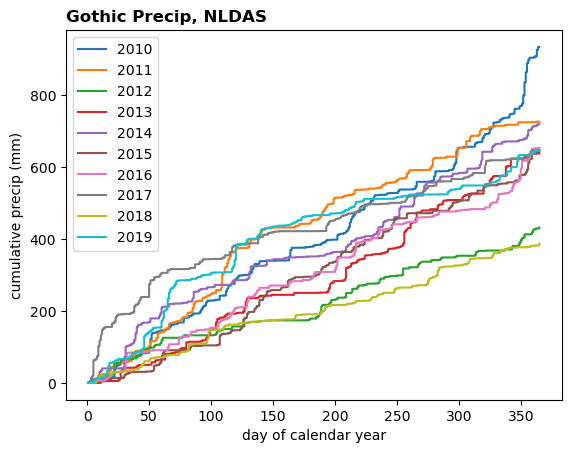

In [94]:
sph=3600
cumPPT = ((ds.PRECTmms.groupby('time.year').cumsum())*sph)

for year in range(2010,2020):
    plot = xr.where(cumPPT['time.year']==year,cumPPT,np.nan)
    x = plot['time.dayofyear']
    y = plot
    plt.plot(x,y,label=str(year))
    
plt.legend()
plt.ylabel('cumulative precip (mm)')
plt.xlabel('day of calendar year')
plt.title('Gothic Precip, NLDAS', loc='left', fontsize='large', fontweight='bold') ;


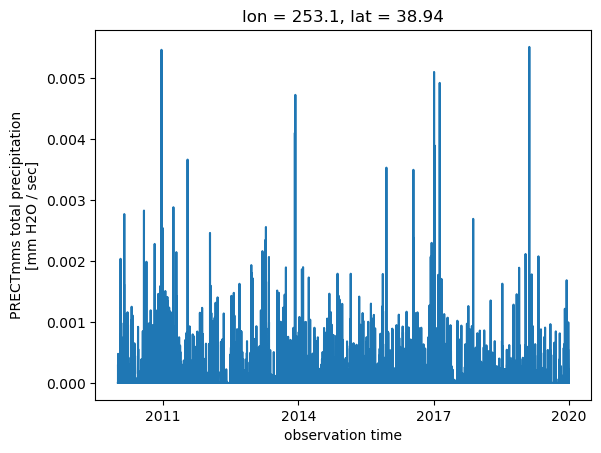

In [44]:
ds_ppt['PRECTmms']
ds_ppt = ds_ppt.assign_coords({'lon': LONG, 'lat':LATI})
ds2 = ds_ppt.sel(lat=plat,lon=plon, method='nearest')
ds2.PRECTmms.plot()

In [48]:
test = xr.open_dataset('/glade/scratch/wwieder/nldas/gothic/test3/run/test3.clm2.h1.2000-01-01-00000.nc', 
                       decode_times=True)

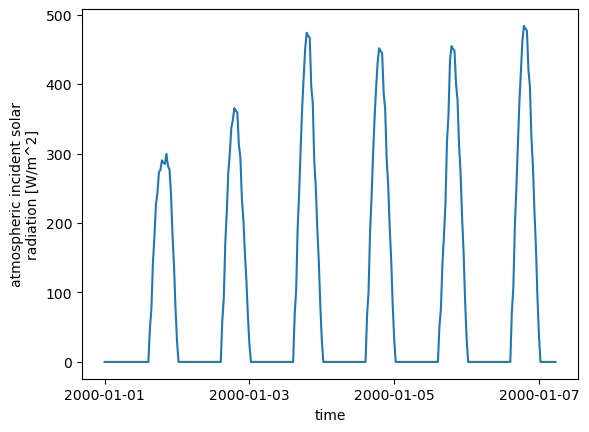

In [52]:
test.FSDS.isel(time=slice(0,300)).plot()

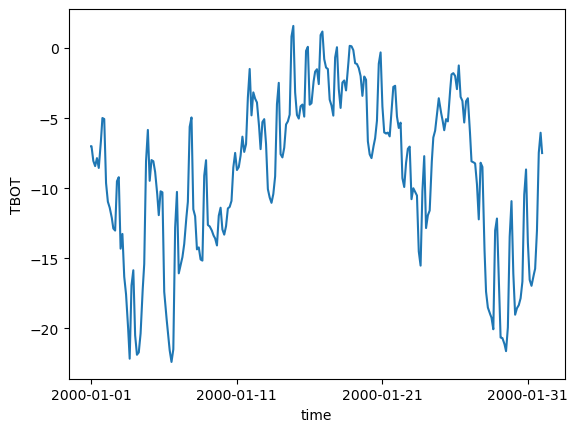

In [54]:
(test.TBOT-273.15).plot()